## Task 1 Visualizing the EMNIST Dataset
Display samples from this dataset in a 5 x C table: columns correspond to character IDs, rows to five random samples from the same category.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import string

import random
import torchvision
from torchvision import datasets, transforms

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
import plotly.express as px
import pandas as pd
from scipy.stats import dirichlet

In [2]:
transform=transforms.Compose([lambda img: torchvision.transforms.functional.rotate(img, -90),
                                transforms.RandomHorizontalFlip(p=1),
                                transforms.ToTensor()])

training_data = datasets.EMNIST(
    root="./data",
    split="byclass",
    download=True,
    transform=transform
)

In [3]:
letters = list(string.digits + string.ascii_uppercase + string.ascii_lowercase)
classes = {}

for img, label in training_data:
    if label in classes:
        if len(classes[label]) < 5:
            classes[label].append(img)
    else:
        classes.update({label: [img]})

<Figure size 2232x2232 with 0 Axes>

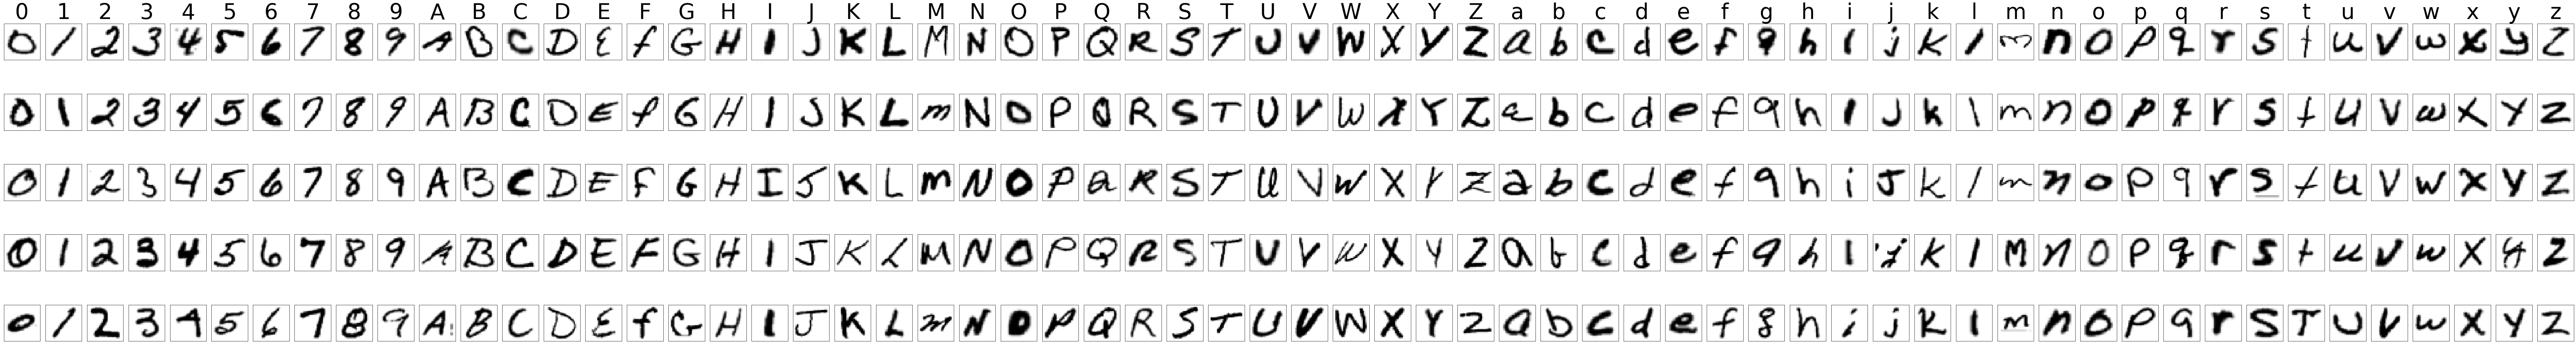

In [4]:
figure = plt.figure(figsize=(31, 31))
cols, rows = 62, 5

fig, axes = plt.subplots(rows, cols, figsize=(100, 15))

for i in range(cols):
    for j in range(rows):
        curr_col = i
        curr_row = j
        img = classes.get(curr_col, [np.zeros((28, 28))])[curr_row]
        ax = axes[j, i]
        ax.imshow(img.squeeze(), cmap=plt.cm.binary)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.set_title(letters[curr_col], fontsize=60)
        
plt.tight_layout()
# plt.savefig("emnist-data.png")
plt.show()

## Task 2 Building a Model
**Task 2.1:** Implement two learning paradigms, MLE and MAP for model parameters, i.e., $p(\theta|D, \alpha, \beta)$, as Estimator Fit method

**Task 2.2:** Then implement predictive models based on each type of learning, i.e., $p(y|x, D, \alpha, \beta) = \int p (y|x, \theta)p (\theta|D, \alpha, \beta)d\theta$, as Estimator Predict method. (Hint: You may want to use Bayes’ Rule here.)

**Task 2.3:** Also implement the scoring methods for the two models $\theta_{MLE}$ and $\theta_{MAP}$

In [5]:
def get_data(data, indices=None, binarize=True):
    N = len(data)
    if indices is None:
        indices = range(0, N)

    # Extract the Xs or the images
    X = np.stack([data[i][0].numpy() for i in indices], axis=1).squeeze(0) # (N,28,28)
    if binarize:
        X = (X > 0.5)
        X = X.astype(int)
    
    # Now extract the Ys or the labels of the images
    y = np.array([data[i][1] for i in indices])

    return X, y

In [6]:
data = datasets.EMNIST(
    root="./data",
    split="balanced",
    download=True,
    transform=transform
)

X, y = get_data(data, binarize=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.90, random_state=0)

In [7]:
class CategoricalNaiveBayes(BaseEstimator):
    def __init__(self, b_i=2.0, b_j=2.0, alpha=1.0, use_map=False):
        self.b_i = b_i  # Beta prior hyperparameter
        self.b_j = b_j    # Beta prior hyperparameter
        self.alpha = alpha # Dirichlet prior hyperparameter
        self.use_map = use_map

    def fit(self, X_fit, y_fit):
        # All part of the Base Estimator parameters
        assert len(X_fit) == len(y_fit)
        self.classes_ = np.unique(y) # unique class labels in the training data
        self.n_classes_ = len(self.classes_) # Number of provided classes
        self.n_features_ = X[0].shape[0] * X[0].shape[1]
        self.class_counts = np.bincount(y_fit) # number of samples from each class
        self.mean_features = []
        
        for c in self.classes_:
            class_mask = (y_fit == c) # in the labels array marks True if C matches the class
            class_features = X_fit[class_mask] # gets all the samples matching the class C
            
            # Adds all the pixels together then normalize
            # p(x|y) probability of a feature appearing given some class C
            if self.use_map:
                self.mean_features.append((class_features.sum(axis=0) + self.b_i - 1) / (self.class_counts[c] + self.b_i + self.b_j - 2))
            else:
                self.mean_features.append((class_features.sum(axis=0) +1) / (self.class_counts[c]+2))
            
        #######
        # We have the following info
        # - Feature Probs: Has the probability that you see a pixel given some class C
        # - Class Counts: The number of samples in each class
        #######
        
        # p(y) probability of Y or probability of a class
        if self.use_map:
            self.class_probs = [(c + self.alpha - 1) / (len(y_fit) + (self.n_classes_ * self.alpha) - self.n_classes_ )for c in self.class_counts]
        else:
            self.class_probs = [c / len(y_fit) for c in self.class_counts]
        
        # get the log values (this will help for prediction)
        self.log_feature_probs = [np.log(fp) for fp in self.mean_features]
        self.log_feature_probs_neg = [np.log(1 - fp) for fp in self.mean_features]
        self.log_class_priors = [np.log(cp) for cp in self.class_probs]
        
    def bayes_calculate(self, x):
        x = np.expand_dims(x, 0)
        
        # See how many of the pixels line up with the priors (can be 0 or 1)
        prob_x_given_y = self.log_feature_probs * x + self.log_feature_probs_neg * (1 - x)
        prob_x_given_y = prob_x_given_y.reshape(self.n_classes_, -1).sum(axis=1)
        return prob_x_given_y + self.log_class_priors
    
    def predict(self, X, y):
        y_preds = [np.argmax(self.bayes_calculate(x)) for x in X]
        return np.mean(y_preds == y)

    def score(self, X, y):

        def score_calc(x):
            prob_x_given_y = self.log_feature_probs * x + self.log_feature_probs_neg * (1 - x)
            prob_x_given_y = np.sum(prob_x_given_y.reshape(self.n_classes_, -1).sum(axis=1))
            return prob_x_given_y

        y_scores = [score_calc(x) for x in X]
        y_scores_sum = sum(y_scores) + np.sum(self.class_counts * self.log_class_priors)
        return y_scores_sum/len(y)

In [8]:
model = CategoricalNaiveBayes(use_map=True)
model.fit(X_train, y_train)
print(model.predict(X_test, y_test))
model.score(X_test, y_test)

0.5398345153664302


-15225.190765940715

## Task 3 Plotting the Learning Curves for Balanced Training Data
Follow the example in this scikit-learn documentation page to plot Learning Curves for the two models. For that purpose, your training dataset will consist of 10% (11280) of EMNIST data points, as defined in ‘emnist_project.py’ (see the folder). For learning curves, use five points, equally spread between 10% and 100% of the training dataset (thus, from 1128 to 11280 data points).

**Task 3.1:** Fix the pixel prior $\beta$ = 1 and plot the training and validation learning curves for $\alpha$ = (1, 10, 50, 100, 200).

**Task 3.2:** Fix the class prior $\alpha$ = 1 and plot the training&validation learning curves for $\beta$ = (1, 2, 10, 100).

In [9]:
# Fix the pixel prior 𝛽 = 1 and plot the training&validation learning curves for 𝛼 = (1, 10, 50, 100, 200)
# NOTE: Fixing the pixel prior to one will result in a divide by zero error, therefore I'll set it to 1.01 instead

learning_df = pd.DataFrame(columns = ['Class Prior', 'Training Samples', 'Accuracy', 'Score', 'Train/Test'])
sizes = [1128, 2820, 5640, 8460, 11280]
dirchlet_priors = [1, 10, 50, 100, 200]

for alpha in dirchlet_priors:
    for s in sizes:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=s, random_state=0)
        model = CategoricalNaiveBayes(b_i=1.01, b_j=1.01, alpha=alpha, use_map=True)
        model.fit(X_train, y_train)

        learning_df = learning_df.append([{'Class Prior': alpha, 'Training Samples': s, 'Accuracy': model.predict(X_train, y_train), 'Score': model.score(X_train, y_train), 'Train/Test': 'Train Score'}])
        learning_df = learning_df.append([{'Class Prior': alpha, 'Training Samples': s, 'Accuracy': model.predict(X_test, y_test), 'Score': model.score(X_test, y_test), 'Train/Test': 'Test Score'}])

In [10]:
learning_df.to_csv('data/task_3_1.csv')

In [11]:
fig_acc = px.line(learning_df, x='Training Samples', y='Accuracy', line_dash='Train/Test', color='Class Prior')
fig_acc.show()

fig_score = px.line(learning_df, x='Training Samples', y='Score', line_dash='Train/Test', color='Class Prior')
fig_score.show()

In [12]:
# Fix the class prior 𝛼 = 1 and plot the training&validation learning curves for 𝛽 = (1, 2, 10, 100)
# NOTE: Fixing the pixel prior to one will result in a divide by zero error, therefore I'll set it to 1.01 instead

learning_df = pd.DataFrame(columns = ['Pixel Prior', 'Training Samples', 'Accuracy', 'Score', 'Train/Test'])
sizes = [1128, 2820, 5640, 8460, 11280]
pixel_prior = [1.01, 2, 10, 100]

for beta in pixel_prior:
    for s in sizes:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=s, random_state=0)
        model = CategoricalNaiveBayes(b_i=beta, b_j=beta, use_map=True)
        model.fit(X_train, y_train)

        learning_df = learning_df.append([{'Pixel Prior': beta, 'Training Samples': s, 'Accuracy': model.predict(X_train, y_train), 'Score': model.score(X_train, y_train), 'Train/Test': 'Train Score'}])
        learning_df = learning_df.append([{'Pixel Prior': beta, 'Training Samples': s, 'Accuracy': model.predict(X_test, y_test), 'Score': model.score(X_test, y_test), 'Train/Test': 'Test Score'}])

In [13]:
learning_df.to_csv('data/task_3_2.csv')

In [14]:
fig_acc = px.line(learning_df, x='Training Samples', y='Accuracy', line_dash='Train/Test', color='Pixel Prior')
fig_acc.show()

fig_score = px.line(learning_df, x='Training Samples', y='Score', line_dash='Train/Test', color='Pixel Prior')
fig_score.show()

## Task 4 Plotting the Learning Curves for Imbalanced Training Data
Although we tend to assume each class has the same degree of importance (that is, in the test set, each class will have same amount of examples), in reality, we sometimes cannot construct such a balanced training set. For example, if we want to do image classification for different species of animals, the examples of cats and dogs can be easily sampled, while the examples of sharks and whales can only be sampled in a lower frequency, which will lead to an imbalanced training dataset. To simulate this imbalanced class distribution, we can use Dirichlet distribution for our training dataset. When constructing the imbalanced training dataset, we assume the ratio of each class is sampled from a Dirichlet distribution with $\alpha_{class1}$ = ... = $\alpha_{classC}$ = $\alpha_{class}$. We first sample the class ratio from this distribution, and then sample examples of each class according to this ratio. By adjusting the value of 𝛼 class , we can construct the training data of different degrees of imbalance. Typically, larger $\alpha_{class}$ will produce more balanced class distribution. Now your task is to compare the performance of the MLE and MAP models in training settings with different degrees of imbalance.

**Task 4.1:** For MAP model, fix the class prior $\alpha$ = 1 and try $\beta$ = (1, 1.2, 2, 10, 100) for $\alpha_{class}$ = (0.1, 0.2, 0.5, 1, 10, 100). Plot the training and validation learning curves and compare its performance with the MLE model.

**Task 4.2:** For MAP model, fix the pixel prior $\beta$ = 1 and try $\alpha$ = (1, 10, 100, 1000) for $\alpha_{class}$ = (0.1, 0.2, 0.5, 1, 10, 100). Plot the training and validation learning curves and compare its performance with the MLE model.

NOTE: Because setting the pixel prior to 1 results in a divide by zero error for MAP, I either skip that part or set it to 1.01

In [28]:
learning_df = pd.DataFrame(columns = ['Dirchlet Proportion', 'Accuracy', 'Train/Test', 'Pixel Prior'])
class_proportion = [0.1, 0.2, 0.5, 1, 10, 100]
pixel_prior = [1.01, 1.2, 2, 10, 100]
n_classes = len(np.unique(y))

for cp in class_proportion:
    sample_rate = dirichlet.rvs([cp] * n_classes, size=1)[0]
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    # loop through and get the corresponding number of samples from each class
    for c, sr in enumerate(sample_rate):
        pseudo_count = 0
        class_mask = (y == c) # in the labels array marks True if C matches the class
        class_features = X[class_mask] # gets all the samples matching the class C
        
        # now generate a mask for the sample rate
        for cf in class_features:
            if random.uniform(0, 1) < sr:
                X_train.append(cf)
                y_train.append(c)
            elif pseudo_count == 0:
                X_train.append(cf)
                y_train.append(c)
                pseudo_count = 1
            else:
                X_test.append(cf)
                y_test.append(c)
                
    X_train = np.stack(X_train)
    y_train = np.array(y_train)
    X_test = np.stack(X_test)
    y_test = np.stack(y_test)

    model = CategoricalNaiveBayes(use_map=False)
    model.fit(X_train, y_train)
    learning_df = learning_df.append([{'Samples': X_train.shape[0], 'Dirchlet Proportion': cp, 'Accuracy': model.predict(X_train, y_train), 'Score': model.score(X_train, y_train), 'Train/Test': 'Train Score', 'Pixel Prior': 'MLE'}])
    learning_df = learning_df.append([{'Samples': X_test.shape[0], 'Dirchlet Proportion': cp, 'Accuracy': model.predict(X_test, y_test), 'Score': model.score(X_test, y_test), 'Train/Test': 'Test Score', 'Pixel Prior': 'MLE'}])
    
    for p in pixel_prior:
        model = CategoricalNaiveBayes(b_i=p, b_j=p, use_map=True)
        model.fit(X_train, y_train)
        learning_df = learning_df.append([{'Dirchlet Proportion': cp, 'Accuracy': model.predict(X_train, y_train), 'Score': model.score(X_train, y_train), 'Train/Test': 'Train Score', 'Pixel Prior': p}])
        learning_df = learning_df.append([{'Dirchlet Proportion': cp, 'Accuracy': model.predict(X_test, y_test), 'Score': model.score(X_test, y_test), 'Train/Test': 'Test Score', 'Pixel Prior': p}])

In [29]:
learning_df.to_csv('data/task_4_1.csv')

In [30]:
fig = px.line(learning_df, x='Dirchlet Proportion', y='Accuracy', color='Pixel Prior', line_dash='Train/Test')
fig.show()

fig = px.line(learning_df, x='Dirchlet Proportion', y='Score', color='Pixel Prior', line_dash='Train/Test')
fig.show()

### MLE vs MAP
It looks like in this situation the lower pixel priors tend to do better no matter the level of imbalance present in the dataset, therefore I might use an MLE rather than MAP if the only thing I want to set is the pixel prior.

In [25]:
learning_df = pd.DataFrame(columns = ['Dirchlet Proportion', 'Score', 'Train/Test', 'Class Prior'])
class_proportion = [0.1, 0.2, 0.5, 1, 10, 100]
class_prior = [1, 10, 100, 1000]
n_classes = len(np.unique(y))

for cp in class_proportion:
    sample_rate = dirichlet.rvs([cp] * n_classes, size=1)[0]
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    # loop through and get the corresponding number of samples from each class
    for c, sr in enumerate(sample_rate):
        pseudo_count = 0
        class_mask = (y == c) # in the labels array marks True if C matches the class
        class_features = X[class_mask] # gets all the samples matching the class C
        
        # now generate a mask for the sample rate
        for cf in class_features:
            if random.uniform(0, 1) < sr:
                X_train.append(cf)
                y_train.append(c)
            elif pseudo_count == 0:
                X_train.append(cf)
                y_train.append(c)
                pseudo_count = 1
            else:
                X_test.append(cf)
                y_test.append(c)
                
    X_train = np.stack(X_train)
    y_train = np.array(y_train)
    X_test = np.stack(X_test)
    y_test = np.stack(y_test)
    
    print(np.bincount(y_train))

    model = CategoricalNaiveBayes(use_map=False)
    model.fit(X_train, y_train)
    learning_df = learning_df.append([{'Samples': X_train.shape[0], 'Dirchlet Proportion': cp, 'Accuracy': model.predict(X_train, y_train), 'Score': model.score(X_train, y_train), 'Train/Test': 'Train Score', 'Class Prior': 'MLE'}])
    learning_df = learning_df.append([{'Samples': X_test.shape[0], 'Dirchlet Proportion': cp, 'Accuracy': model.predict(X_test, y_test), 'Score': model.score(X_test, y_test), 'Train/Test': 'Test Score', 'Class Prior': 'MLE'}])
        
    for p in class_prior:
        model = CategoricalNaiveBayes(alpha=p, use_map=True)
        model.fit(X_train, y_train)
        learning_df = learning_df.append([{'Samples': X_train.shape[0], 'Dirchlet Proportion': cp, 'Accuracy': model.predict(X_train, y_train), 'Score': model.score(X_train, y_train), 'Train/Test': 'Train Score', 'Class Prior': p}])
        learning_df = learning_df.append([{'Samples': X_test.shape[0], 'Dirchlet Proportion': cp, 'Accuracy': model.predict(X_test, y_test), 'Score': model.score(X_test, y_test), 'Train/Test': 'Test Score', 'Class Prior': p}])

[  1   1   1  10  11   1   1   3 436   2 132   1   1 215   1 331   1   2
 387   1   1 685   1   1   1   1 157  55  10   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1]
[  1 140  79   1 165   1   2 640   2  52   1  30   1   1 115   7 762  12
   1   1   3  88   3   1  21   5   7 167  14  33   4   1   1   7   2   1
  30  24   4   1  15   1   5   1  11   1   1]
[ 32  32  70  36 113   2 120  93   1   4   2   4   2   1 115  22  24  16
  61  58 404  29 318  30   4   7   9   2 130   1  64  47   1   1   3   1
 326  30  19   4  28  33  13   4  15   3  92]
[ 17 126  61 117   3  34 131  48  10   7  61  88  11   1  71 109  21  40
   8  54  52  87  70  62  25  14  11  50  23   4  24  28  75   8 137   8
  28 183 240   6  49   4   5  33  92  14  40]
[63 34 40 79 32 56 42 42 38 89 40 39 91 58 54 51 49 39 43 47 41 39 31 79
 48 85 32 42 36 37 47 41 54 56 55 54 58 29 44 55 70 57 52 81 61 62 75]
[57 58 55 55 42 41 52 57 56 49 48 54 66 57 55 49 50 54 66 41 57 51 41 66
 46 51 59 52 60

In [26]:
learning_df.to_csv('data/task_4_2.csv')

In [27]:
fig = px.line(learning_df, x='Dirchlet Proportion', y='Accuracy', color='Class Prior', line_dash='Train/Test')
fig.show()

fig = px.line(learning_df, x='Dirchlet Proportion', y='Score', color='Class Prior', line_dash='Train/Test')
fig.show()

### MLE vs MAP
If you look close enough in the accuracy graph, you'll see that the best class prior for imbalanced tends to be $\alpha=10$, this is because the prior value helps out when the data is very imbalanced. As the data gets more balanced, the lower class priors tend to be better and when the data is balanced, the class prior does not help at all.

## Task 5 Discuss performance of different models

**Task 5.1:** How does the generalization performance of each model change as a function of the amount of training data and the choice of hyper-parameters?

It looks like the amount of training data makes a difference between the test and train sections. For example, if you look at the task 3 graphs, you'll see that the model trained on a smaller training dataset tends to suffer when it comes to test time. This is likely due to underfitting since the model is not able to understand the bitmaps completely. It looks like at around 2820 datapoints the test curve becomes flat and so if I were to choose a percentage of data to train on I would choose the train set to be 20%. It is also important to note that class prior makes little to no difference when working with balanced data.

**Task 5.2:** Which model would you select for deployment and why?

The class proportions made no difference for testing/training accuracy in the balanced data situation, and the pixel priors decrease the test/train accuracy. Therefore if I had a balanced dataset, I would use a maximum likelihood estimation model where the training dataset is 20% of the total dataset. If I had an imbalanced dataset, I would likely use MAP with a slight class prior of $\alpha=10$ to use my prior information to inform the model. I would not use a pixel prior in either situation and would rather opt for a much simpler laplace smoothing to avoid a divide by zero error.